/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


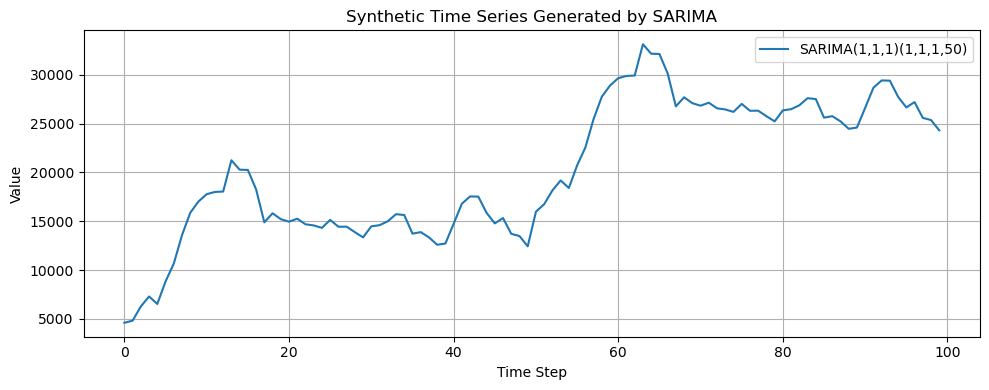

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fixing the simulation by first fitting a model to get initial parameters
def generate_sarima_series_fixed(
    n=500,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 50),
    noise_std=1.0,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # Simulate white noise as a placeholder to fit initial model
    noise = np.random.normal(scale=noise_std, size=n)

    # Fit SARIMA model to get parameters
    model = SARIMAX(
        endog=noise,
        order=order,
        seasonal_order=seasonal_order,
        trend='n',
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    fit_result = model.fit(disp=False)

    # Simulate using the fitted parameters
    simulated = model.simulate(params=fit_result.params, nsimulations=n)
    df_sarima = pd.DataFrame({'value': simulated}, index=np.arange(n))
    return df_sarima

# Generate SARIMA data
df_sarima_fixed = generate_sarima_series_fixed(
    n=100,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 50),
    noise_std=1.0,
    seed=42
)

# Plot the generated SARIMA series
plt.figure(figsize=(10, 4))
plt.plot(df_sarima_fixed.index, df_sarima_fixed['value'], label="SARIMA(1,1,1)(1,1,1,50)")
plt.title("Synthetic Time Series Generated by SARIMA")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

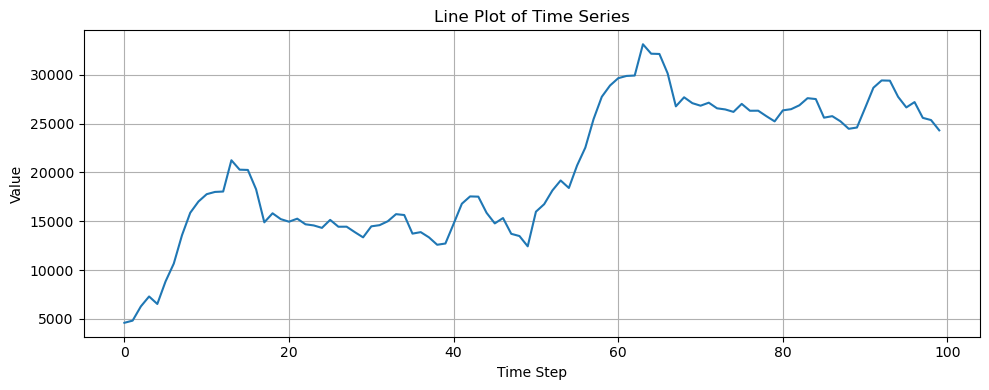

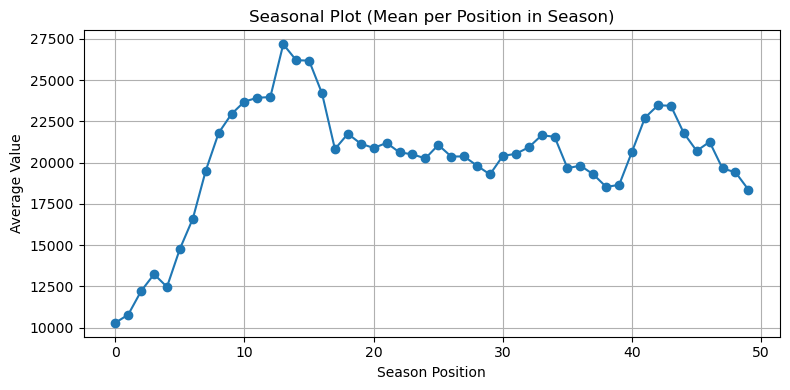

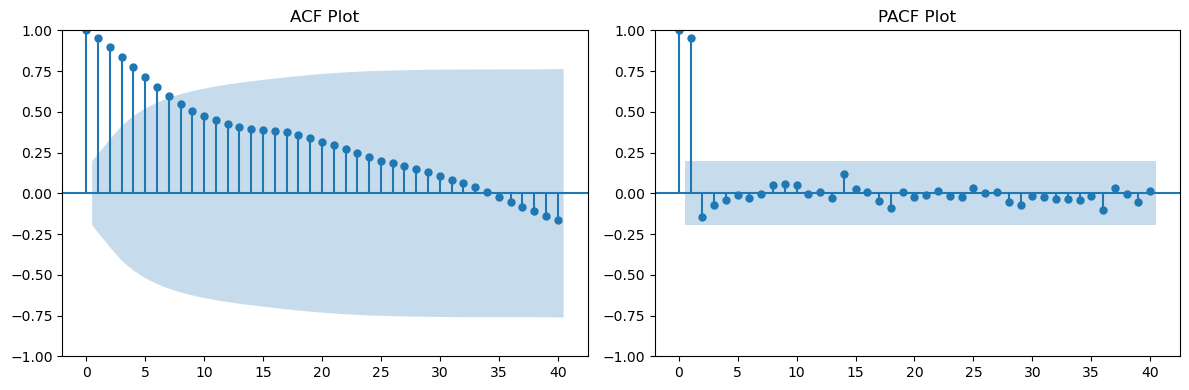

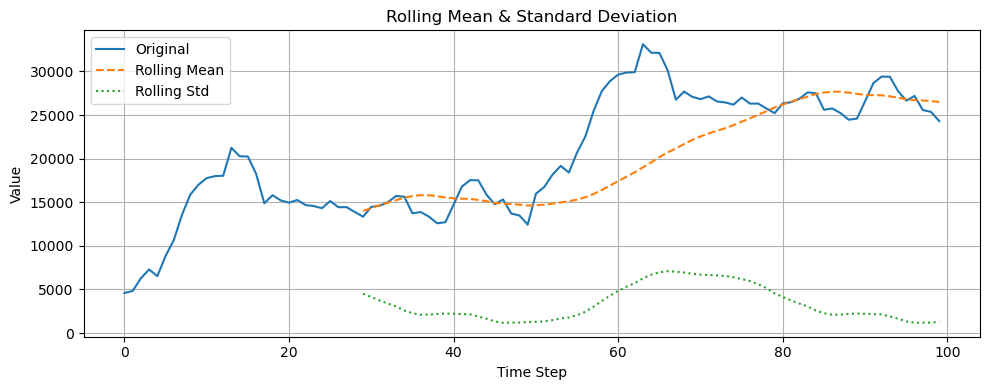

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use ARIMA-style data for analysis
series = df_sarima_fixed['value']
index = df_sarima_fixed.index

# 1. Line plot
plt.figure(figsize=(10, 4))
plt.plot(index, series)
plt.title("Line Plot of Time Series")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Seasonal plot: simulate seasonality by plotting in chunks
season_length = 50
season_df = pd.DataFrame({
    'season': [i % season_length for i in range(len(series))],
    'value': series.values
})
season_avg = season_df.groupby('season').mean()

plt.figure(figsize=(8, 4))
plt.plot(season_avg.index, season_avg['value'], marker='o')
plt.title("Seasonal Plot (Mean per Position in Season)")
plt.xlabel("Season Position")
plt.ylabel("Average Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series, ax=axes[0], lags=40)
plot_pacf(series, ax=axes[1], lags=40)
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()

# 4. Rolling mean and standard deviation
rolling_mean = series.rolling(window=30).mean()
rolling_std = series.rolling(window=30).std()

plt.figure(figsize=(10, 4))
plt.plot(series, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', linestyle='--')
plt.plot(rolling_std, label='Rolling Std', linestyle=':')
plt.title("Rolling Mean & Standard Deviation")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


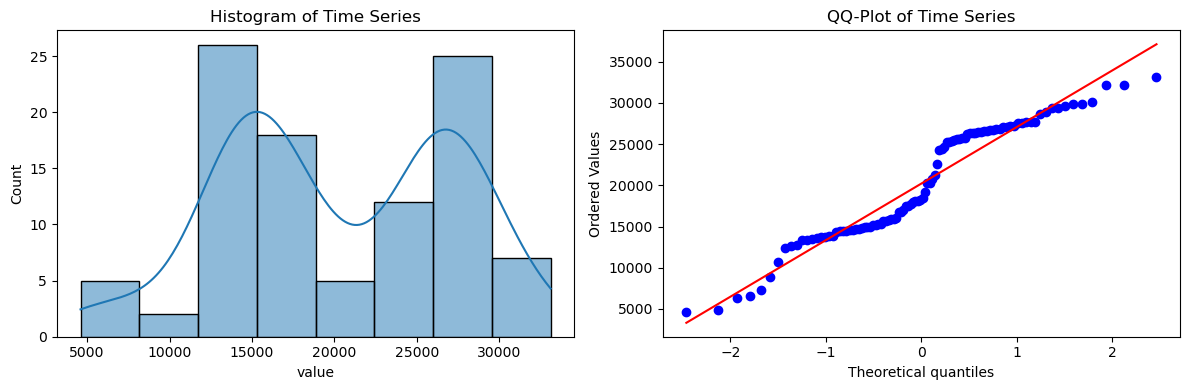

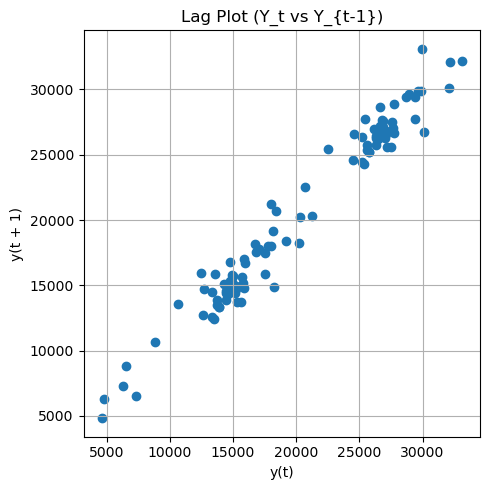

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
import scipy.stats as stats
from pandas.plotting import lag_plot

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
sns.histplot(series, kde=True, ax=axes[0])
axes[0].set_title("Histogram of Time Series")

# QQ-plot
stats.probplot(series, dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot of Time Series")

plt.tight_layout()
plt.show()

# Lag plot
plt.figure(figsize=(5, 5))
lag_plot(series)
plt.title("Lag Plot (Y_t vs Y_{t-1})")
plt.grid(True)
plt.tight_layout()
plt.show()


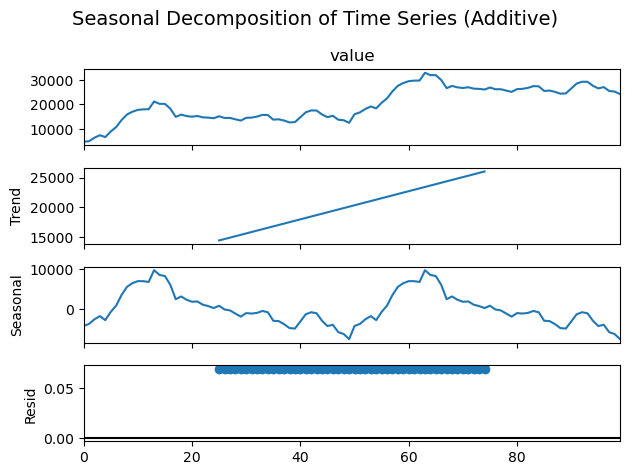

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(series, model='additive', period=50)

# Plot the components
result.plot()
plt.suptitle("Seasonal Decomposition of Time Series (Additive)", fontsize=14)
plt.tight_layout()
plt.show()


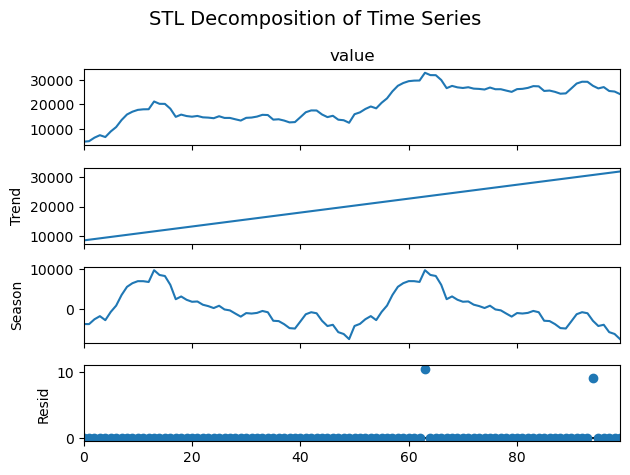

In [12]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition
stl = STL(series, period=50, robust=True)
stl_result = stl.fit()

# Plot STL components
stl_result.plot()
plt.suptitle("STL Decomposition of Time Series", fontsize=14)
plt.tight_layout()
plt.show()


In [14]:
from statsmodels.tsa.arima_process import ArmaProcess

def generate_stochastic_series(
    n=500,
    ar_params=[0.75],          # AR coefficients (e.g., AR(1): [0.75])
    ma_params=[-0.25],         # MA coefficients (e.g., MA(1): [-0.25])
    d=0,                       # Differencing order (I(d) component)
    noise_std=1.0,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # Add leading 1 for statsmodels convention
    ar = np.r_[1, -np.array(ar_params)]
    ma = np.r_[1, np.array(ma_params)]

    arma_process = ArmaProcess(ar, ma)

    # Generate ARMA sample
    arma_sample = arma_process.generate_sample(nsample=n + d, scale=noise_std)

    # Apply differencing if needed
    if d > 0:
        for _ in range(d):
            arma_sample = np.cumsum(arma_sample)

    # Create DataFrame
    df_stochastic = pd.DataFrame({
        'value': arma_sample[d:]
    }, index=np.arange(n))

    return df_stochastic

# Generate example ARIMA(1,1,1) process
df_stochastic_example = generate_stochastic_series(
    n=500,
    ar_params=[0.75],
    ma_params=[-0.25],
    d=1,
    noise_std=1.0,
    seed=42
)

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Regenerate synthetic ARIMA(1,1,1) series
series_A = generate_stochastic_series(n=500, ar_params=[0.75], ma_params=[-0.25], d=1, seed=1)['value']
series_B = generate_stochastic_series(n=500, ar_params=[0.75], ma_params=[-0.25], d=1, seed=2)['value']
series_C = generate_stochastic_series(n=500, ar_params=[0.75], ma_params=[-0.25], d=1, seed=3)['value']

# Fit ARIMA and forecast
def fit_arima_forecast(series):
    model = ARIMA(series, order=(1, 1, 1))
    fit = model.fit()
    forecast = fit.predict(start=0, end=len(series) - 1)
    return forecast, series

pred_A, true_A = fit_arima_forecast(series_A)
pred_B, true_B = fit_arima_forecast(series_B)
pred_C, true_C = fit_arima_forecast(series_C)

# Evaluation function
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Recompute evaluation metrics using the previous predictions
results = pd.DataFrame([
    evaluate_forecast(true_A, pred_A),
    evaluate_forecast(true_B, pred_B),
    evaluate_forecast(true_C, pred_C)
], index=["Series A", "Series B", "Series C"])

results

,MAE,RMSE,MAPE
Series A,0.791382,0.992179,5.658193
Series B,0.820178,1.032770,15.104207
Series C,0.825604,1.032390,12.480416
